In [1]:
## matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.figsize'] = 8, 8
from IPython.display import Image

In [3]:
import pymc3 as pm
import random
import numpy as np
from scipy.stats import beta, binom, bernoulli
import pandas as pd
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from collections import Counter

In [4]:
def normalize(array):
    sums = sum(array)
    return np.array([x / sums for x in array])

# Chapter 9: Heirarchical Models

Heirarchical models are mathematical models in which the credible value of a parameter is dependent on another parameter. Because of this, Baye's rule can be factored into a change of dependencies, as below:

$$ p(\theta, \omega | D) = p(D \vert \omega,\theta)p(\theta, \omega) $$
$$ = p(D \vert \theta)p(\theta \vert \omega)p(\omega) $$

## A single coin from a single mint

Given a bernoulli likelihood function, $ y_i \sim Bern(\theta) $, and a prior beta distribution, $\theta \sim Beta(a,b)$. This can be rewritten as, 

$$ \theta \sim Beta(\omega(\kappa - 2)+1, (1-\omega)(\kappa - 2) + 1) $$

where, along with $\theta$, $\omega$ is another parameter to be estimated. Some minted coins have a $\theta$ greater than $\omega$ while some are less. If $\kappa$ is large, there is a greater chance that $\theta$ is close to $\omega$. So, given a series of flips, $\theta$ can be estimated from the proportion of heads. if $\kappa$ is large, we know that $\omega$ is close to $\theta$.

We also define a prior distribution on $\omega$ to explain how the mints are constructred. In this case, we use a beta distribution, 

$$ p(\omega) = Beta(\omega \vert A_{\omega},B_{\omega}) $$

Thus, the typical value of $\omega$ is near the mode of the distribution, $\frac{A_{\omega} - 1}{A_{\omega} + B_{\omega} + 2}$. 

We are solving $p(\theta,\omega \vert y)$. Because the likelihood function does not include $\omega$, $p(y \vert \omega , \theta) = p(y \vert \theta)$. Therefore, 

$$p(y \vert \omega , \theta) = \frac{p(y \vert \omega , \theta)p(\theta,\omega)}{p(y)}$$
$$ = \frac{p(y \vert \theta)p(\theta \vert \omega)p(\omega)}{p(y)}$$

### Posterior distribution via grid approximation

Complicated heirarchical models very rarely have simple posterior distributions. Assuming $A_{\omega} = 2$, $B_{\omega} = 2$, N = 12, and 9 heads, the prior, likelihood, and posterior distribution are shown below.

#### Prior

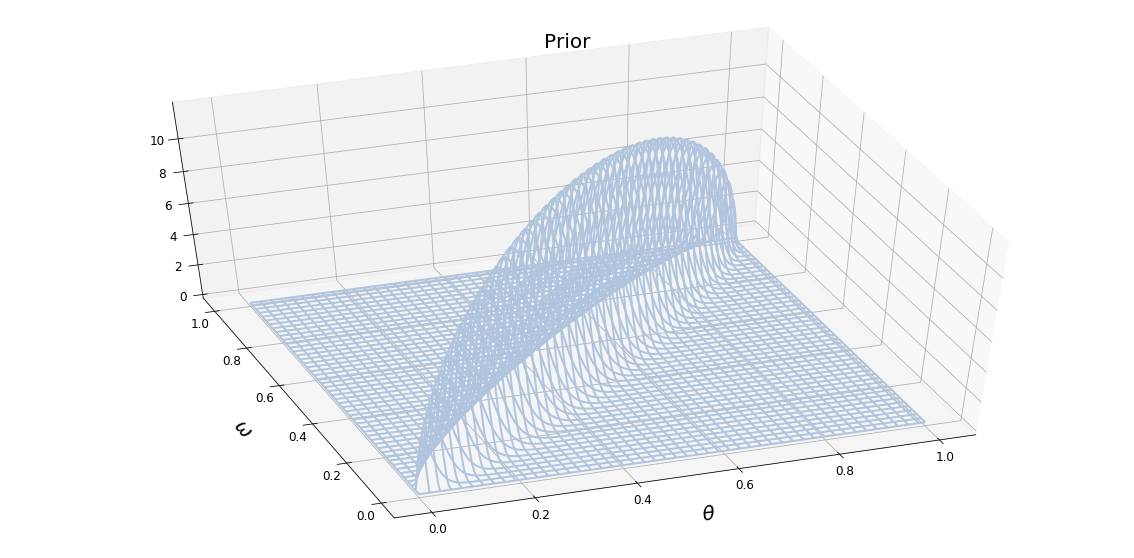

In [5]:
# plot the 3d prior
a = b = 2
k = 100
thetas = omegas = np.linspace(0,1,1001)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(thetas, omegas)

prior = beta.pdf(X,Y*(k - 2) + 1,(1-Y)*(k - 2) + 1)*beta.pdf(Y,a,b)

ax.plot_wireframe(X, Y, prior, color = 'lightsteelblue');
ax.set_title('Prior')
ax.set_xlabel(r'$\theta$', labelpad=20);
ax.set_ylabel(r'$\omega$', labelpad=20);
ax.view_init(azim=250, elev= 50)
fig.tight_layout()

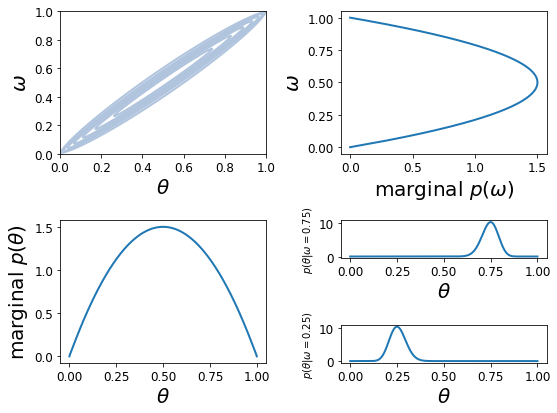

In [5]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(4, 2)

ax0 = plt.subplot(gs[0:2,0])
ax0.contour(thetas, omegas, prior, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta$')
ax0.set_ylabel(r'$\omega$')

ax1 = plt.subplot(gs[2:4,0])
ax1.plot(thetas, np.sum(prior,axis = 0) / len(thetas))
ax1.set_ylabel(r'marginal $p(\theta)$')
ax1.set_xlabel(r'$\theta$')

ax2 = plt.subplot(gs[0:2,1])
ax2.plot(normalize(np.sum(prior,axis = 1)) * len(omegas), omegas)
ax2.set_xlabel(r'marginal $p(\omega)$')
ax2.set_ylabel(r'$\omega$')

ax3 = plt.subplot(gs[2:3,1])
ax3.plot(thetas, prior[750])
ax3.set_xlabel(r'$\theta$')
ax3.set_ylabel(r'$p(\theta \vert \omega = 0.75)$', fontsize = 10)

ax4 = plt.subplot(gs[3:4,1])
ax4.plot(thetas, prior[250])
ax4.set_xlabel(r'$\theta$')
ax4.set_ylabel(r'$p(\theta \vert \omega = 0.25)$', fontsize = 10)


plt.tight_layout()
plt.show()

#### Likelihood

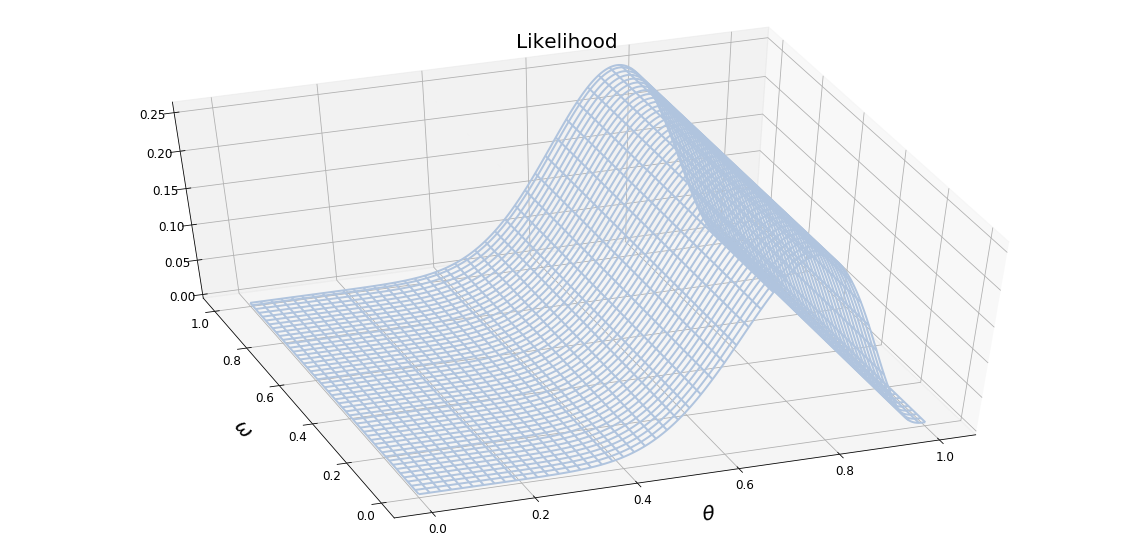

In [6]:
# plot the 3d prior
z = 12
h = 9
t = z - h
thetas = omegas = np.linspace(0,1,1001)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(thetas, omegas)

likelihood = binom.pmf(h,z,X)

ax.plot_wireframe(X, Y, likelihood, color = 'lightsteelblue');
ax.set_title('Likelihood')
ax.set_xlabel(r'$\theta$', labelpad=20);
ax.set_ylabel(r'$\omega$', labelpad=20);
ax.view_init(azim=250, elev= 50)
fig.tight_layout()

#### Posterior

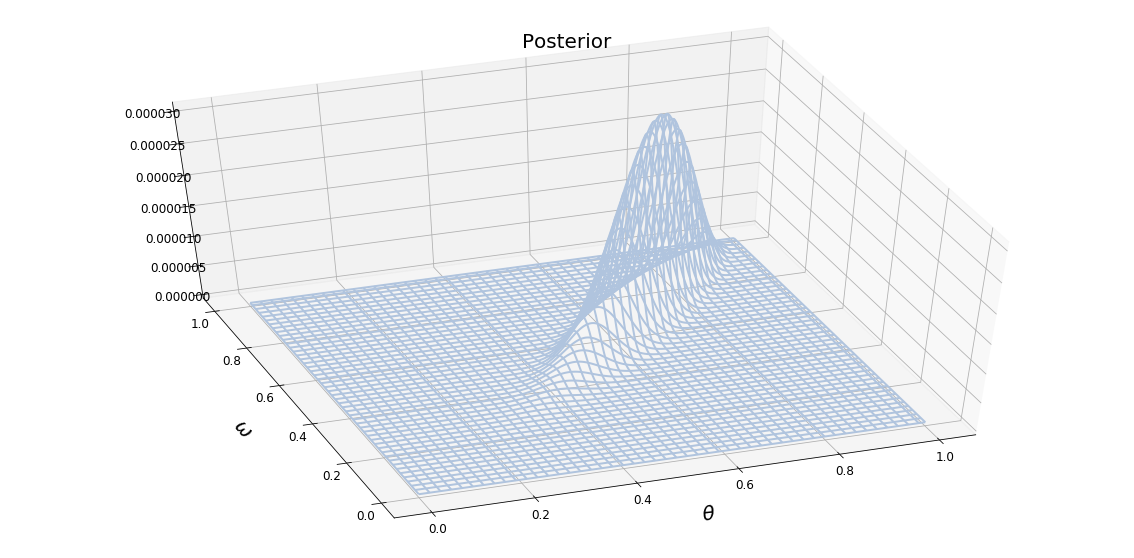

In [7]:
# plot the 3d posterior
a = b = 2
k = 100
thetas = omegas = np.linspace(0,1,1001)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(thetas, omegas)

prob_data = np.multiply(prior,likelihood).sum()
posterior = np.multiply(prior,likelihood) / prob_data

ax.plot_wireframe(X, Y, posterior, color = 'lightsteelblue');
ax.set_title('Posterior')
ax.set_xlabel(r'$\theta$', labelpad=20);
ax.set_ylabel(r'$\omega$', labelpad=20);
ax.view_init(azim=250, elev= 50)
fig.tight_layout()

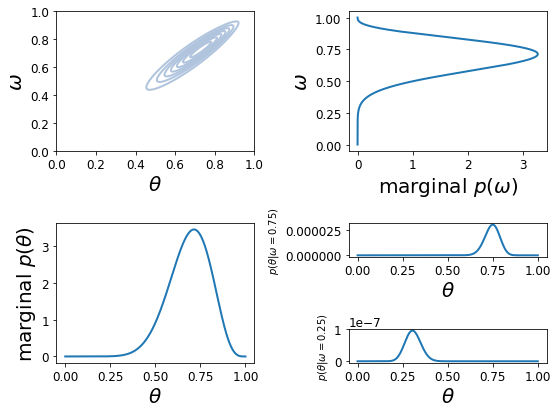

In [8]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(4, 2)

ax0 = plt.subplot(gs[0:2,0])
ax0.contour(thetas, omegas, posterior, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta$')
ax0.set_ylabel(r'$\omega$')

ax1 = plt.subplot(gs[2:4,0])
ax1.plot(thetas, np.sum(posterior,axis = 0) * len(thetas))
ax1.set_ylabel(r'marginal $p(\theta)$')
ax1.set_xlabel(r'$\theta$')

ax2 = plt.subplot(gs[0:2,1])
ax2.plot(np.sum(posterior,axis = 1) * len(omegas), omegas)
ax2.set_xlabel(r'marginal $p(\omega)$')
ax2.set_ylabel(r'$\omega$')

ax3 = plt.subplot(gs[2:3,1])
ax3.plot(thetas, posterior[750])
ax3.set_xlabel(r'$\theta$')
ax3.set_ylabel(r'$p(\theta \vert \omega = 0.75)$', fontsize = 10)

ax4 = plt.subplot(gs[3:4,1])
ax4.plot(thetas, posterior[250])
ax4.set_xlabel(r'$\theta$')
ax4.set_ylabel(r'$p(\theta \vert \omega = 0.25)$', fontsize = 10)


plt.tight_layout()
plt.show()

Below is another example in which there is a high prior certainty on $\omega$ but a low certainty regarding the dependence of $\theta$ on $\omega$. Assuming $A_{\omega} = 20$, $B_{\omega} = 20$, $\kappa = 6$, N = 12, and 9 heads, the prior, likelihood, and posterior distribution are shown below.

#### Prior

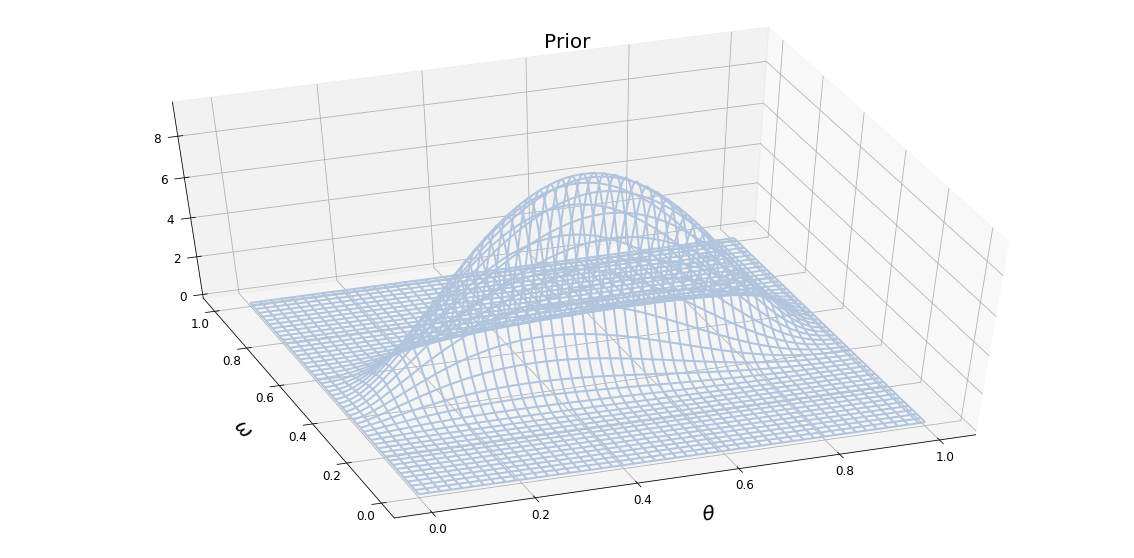

In [9]:
# plot the 3d prior
a = b = 20
k = 6
thetas = omegas = np.linspace(0,1,1001)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(thetas, omegas)

prior = beta.pdf(X,Y*(k - 2) + 1,(1-Y)*(k - 2) + 1)*beta.pdf(Y,a,b)

ax.plot_wireframe(X, Y, prior, color = 'lightsteelblue');
ax.set_title('Prior')
ax.set_xlabel(r'$\theta$', labelpad=20);
ax.set_ylabel(r'$\omega$', labelpad=20);
ax.view_init(azim=250, elev= 50)
fig.tight_layout()

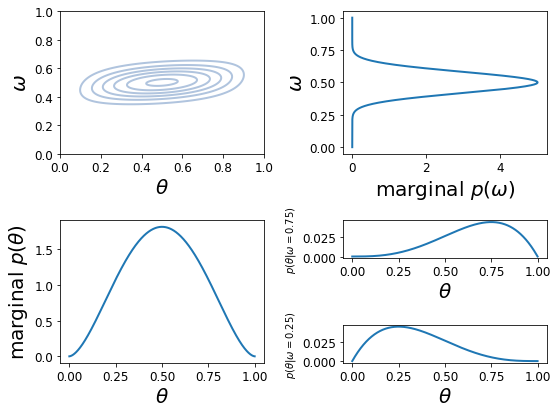

In [10]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(4, 2)

ax0 = plt.subplot(gs[0:2,0])
ax0.contour(thetas, omegas, prior, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta$')
ax0.set_ylabel(r'$\omega$')

ax1 = plt.subplot(gs[2:4,0])
ax1.plot(thetas, normalize(np.sum(prior,axis = 0)) * len(thetas))
ax1.set_ylabel(r'marginal $p(\theta)$')
ax1.set_xlabel(r'$\theta$')

ax2 = plt.subplot(gs[0:2,1])
ax2.plot(normalize(np.sum(prior,axis = 1)) * len(omegas), omegas)
ax2.set_xlabel(r'marginal $p(\omega)$')
ax2.set_ylabel(r'$\omega$')

ax3 = plt.subplot(gs[2:3,1])
ax3.plot(thetas, prior[750])
ax3.set_xlabel(r'$\theta$')
ax3.set_ylabel(r'$p(\theta \vert \omega = 0.75)$', fontsize = 10)

ax4 = plt.subplot(gs[3:4,1])
ax4.plot(thetas, prior[250])
ax4.set_xlabel(r'$\theta$')
ax4.set_ylabel(r'$p(\theta \vert \omega = 0.25)$', fontsize = 10)


plt.tight_layout()
plt.show()

#### Likelihood

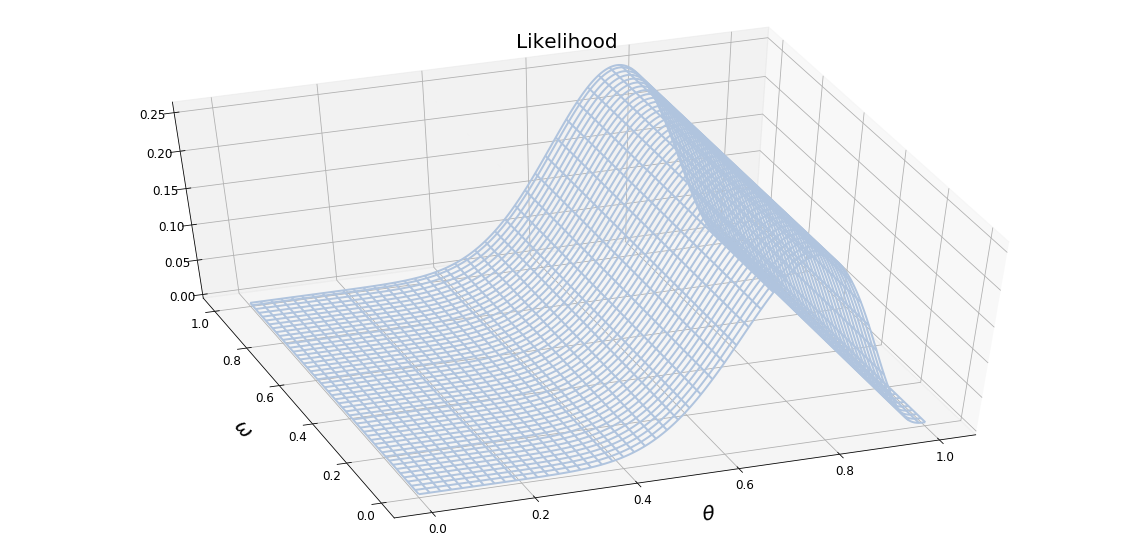

In [11]:
# plot the 3d prior
z = 12
h = 9
t = z - h
thetas = omegas = np.linspace(0,1,1001)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(thetas, omegas)

likelihood = binom.pmf(h,z,X)

ax.plot_wireframe(X, Y, likelihood, color = 'lightsteelblue');
ax.set_title('Likelihood')
ax.set_xlabel(r'$\theta$', labelpad=20);
ax.set_ylabel(r'$\omega$', labelpad=20);
ax.view_init(azim=250, elev= 50)
fig.tight_layout()

#### Posterior

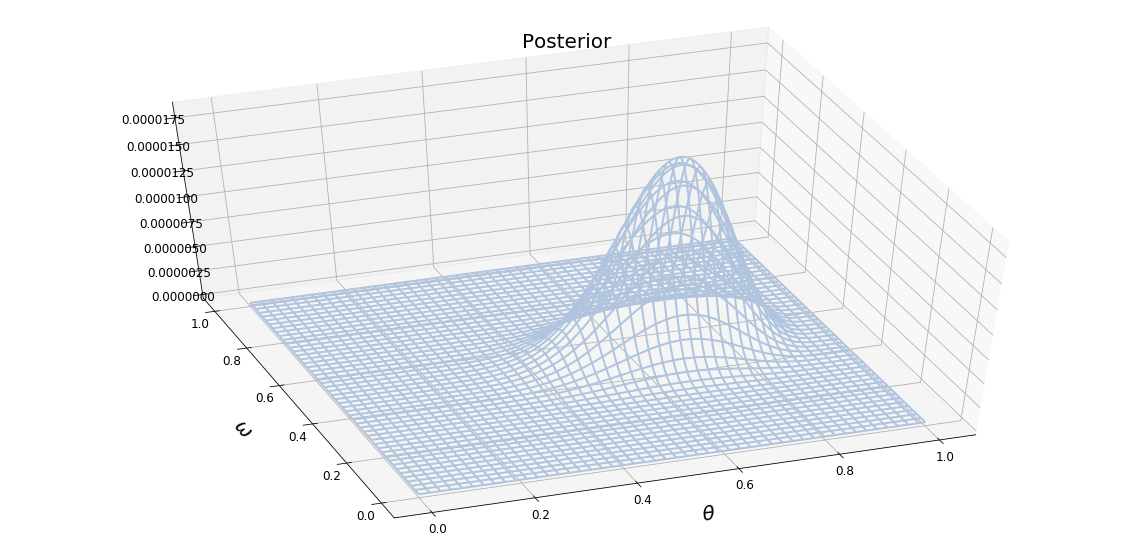

In [12]:
# plot the 3d posterior
a = b = 20
k = 6
thetas = omegas = np.linspace(0,1,1001)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(thetas, omegas)

prob_data = np.multiply(prior,likelihood).sum()
posterior = np.multiply(prior,likelihood) / prob_data

ax.plot_wireframe(X, Y, posterior, color = 'lightsteelblue');
ax.set_title('Posterior')
ax.set_xlabel(r'$\theta$', labelpad=20);
ax.set_ylabel(r'$\omega$', labelpad=20);
ax.view_init(azim=250, elev= 50)
fig.tight_layout()

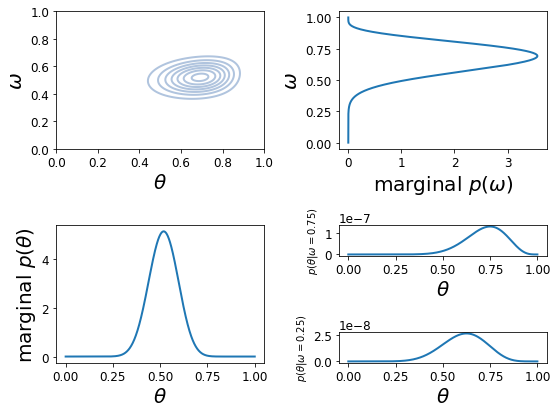

In [13]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(4, 2)

ax0 = plt.subplot(gs[0:2,0])
ax0.contour(thetas, omegas, posterior, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta$')
ax0.set_ylabel(r'$\omega$')

ax1 = plt.subplot(gs[2:4,0])
ax1.plot(thetas, normalize(np.sum(posterior,axis = 1)) * len(thetas))
ax1.set_ylabel(r'marginal $p(\theta)$')
ax1.set_xlabel(r'$\theta$')

ax2 = plt.subplot(gs[0:2,1])
ax2.plot(np.sum(posterior,axis = 0) * len(omegas), omegas)
ax2.set_xlabel(r'marginal $p(\omega)$')
ax2.set_ylabel(r'$\omega$')

ax3 = plt.subplot(gs[2:3,1])
ax3.plot(thetas, posterior[750])
ax3.set_xlabel(r'$\theta$')
ax3.set_ylabel(r'$p(\theta \vert \omega = 0.75)$', fontsize = 10)

ax4 = plt.subplot(gs[3:4,1])
ax4.plot(thetas, posterior[250])
ax4.set_xlabel(r'$\theta$')
ax4.set_ylabel(r'$p(\theta \vert \omega = 0.25)$', fontsize = 10)


plt.tight_layout()
plt.show()

## Multiple Coins from a Single Mint

Now assume a scenario in which have multiple coins from the same mint. Each coin has its own distinct $\theta$ and then from this, we can estimate $\omega$. A common real life example is in drug research. 

A drug (mint) is given to a set of people (coins). The people complete a word memorization task with probability $\theta_s$. The variation in the effect of the drug is denoted as $\omega$. The variation on each person is modele as 

$$ \theta_s \sim Beta(\omega(\kappa - 2)+1, (1-\omega)(\kappa - 2) + 1) $$

The performance of each person is independent and is modeled as $y_{i,s} \sim Bern(\theta_s)$. Given N people, we must estimate N + 1 parameters, $(\theta_1, \theta_2,...,\theta_N,\omega)$.

### Posterior Grid Approximation

In this example, let us assume N = 2. We need to estiamte the variance of the two people ($\theta$) and the effect of the drug ($\omega$). We also assume that the performance of each individual is weakly dependent on the drug. Thus, the prior is a beta distribution with $A_w = B_w = 2$ and $\kappa = 5$.

##### Prior

In [14]:
# plot the 3d prior
a = b = 2
k = 5
thetas = omegas = np.linspace(0,1,1001)

T1, Omega1 = np.meshgrid(thetas, omegas)
T2, Omega2 = np.meshgrid(thetas, omegas)

prior1 = beta.pdf(T1,Omega1*(k - 2) + 1,(1-Omega1)*(k - 2) + 1)*beta.pdf(Omega1,a,b)
prior2 = beta.pdf(T2,Omega2*(k - 2) + 1,(1-Omega2)*(k - 2) + 1)*beta.pdf(Omega2,a,b)

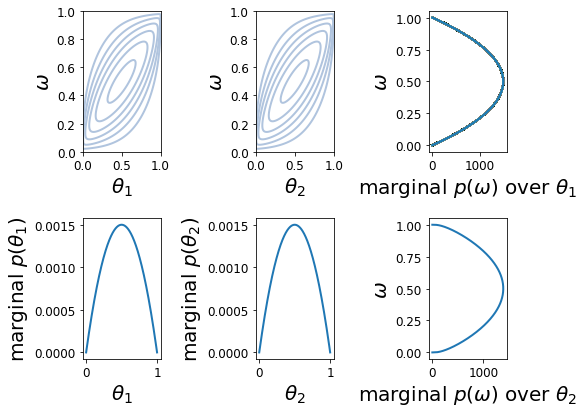

In [15]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3)

ax0 = plt.subplot(gs[0,0])
ax0.contour(T1, Omega1, prior1, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta_1$')
ax0.set_ylabel(r'$\omega$')

ax0 = plt.subplot(gs[0,1])
ax0.contour(T2, Omega2, prior2, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta_2$')
ax0.set_ylabel(r'$\omega$')

ax2 = plt.subplot(gs[0,2])
ax2.plot(np.sum(prior1,axis = 1), Omega1)
ax2.set_xlabel(r'marginal $p(\omega)$ over $\theta_1$')
ax2.set_ylabel(r'$\omega$')

ax3 = plt.subplot(gs[1,0])
ax3.plot(thetas, normalize(np.sum(prior1,axis = 1)))
ax3.set_ylabel(r'marginal $p(\theta_1)$')
ax3.set_xlabel(r'$\theta_1$')

ax4 = plt.subplot(gs[1,1])
ax4.plot(thetas, normalize(np.sum(prior2,axis = 1)))
ax4.set_ylabel(r'marginal $p(\theta_2)$')
ax4.set_xlabel(r'$\theta_2$')

ax5 = plt.subplot(gs[1,2])
ax5.plot(np.sum(prior2,axis = 0), omegas)
ax5.set_xlabel(r'marginal $p(\omega)$ over $\theta_2$')
ax5.set_ylabel(r'$\omega$')

fig.tight_layout()

##### Posterior

In [16]:
## Person 1
Number_words_1 = 15
Memorized_1 = 3

## Person 2
Number_words_2 = 5
Memorized_2 = 4

likelihood_1 = binom.pmf(Memorized_1, Number_words_1,T1)
likelihood_2 = binom.pmf(Memorized_2, Number_words_2,T2)

prob_data_1 = np.multiply(prior1,likelihood_1).sum()
posterior_1 = np.multiply(prior1,likelihood_1) / prob_data_1

prob_data_2 = np.multiply(prior2,likelihood_2).sum()
posterior_2 = np.multiply(prior2,likelihood_2) / prob_data_2

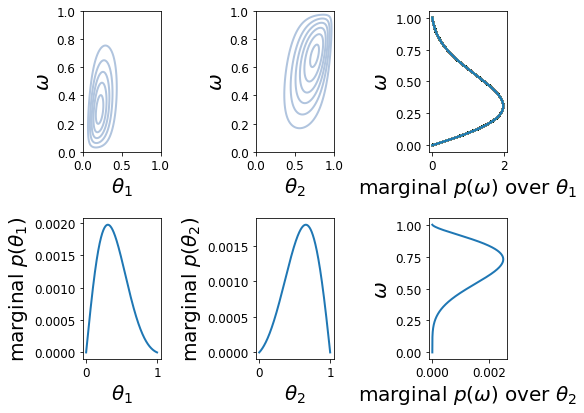

In [17]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3)

ax0 = plt.subplot(gs[0,0])
ax0.contour(T1, Omega1, posterior_1, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta_1$')
ax0.set_ylabel(r'$\omega$')

ax0 = plt.subplot(gs[0,1])
ax0.contour(T2, Omega2, posterior_2, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta_2$')
ax0.set_ylabel(r'$\omega$')

ax2 = plt.subplot(gs[0,2])
ax2.plot(normalize(np.sum(posterior_1,axis = 1)) * len(Omega1), Omega1)
ax2.set_xlabel(r'marginal $p(\omega)$ over $\theta_1$')
ax2.set_ylabel(r'$\omega$')

ax3 = plt.subplot(gs[1,0])
ax3.plot(thetas, normalize(np.sum(posterior_1,axis = 1)))
ax3.set_ylabel(r'marginal $p(\theta_1)$')
ax3.set_xlabel(r'$\theta_1$')

ax4 = plt.subplot(gs[1,1])
ax4.plot(thetas, normalize(np.sum(posterior_2,axis = 1)))
ax4.set_ylabel(r'marginal $p(\theta_2)$')
ax4.set_xlabel(r'$\theta_2$')

ax5 = plt.subplot(gs[1,2])
ax5.plot(np.sum(posterior_2,axis = 0), omegas)
ax5.set_xlabel(r'marginal $p(\omega)$ over $\theta_2$')
ax5.set_ylabel(r'$\omega$')

fig.tight_layout()

Now, let us use assume the dependancy of $\theta$ and $\omega$ is much stronger by setting $\kappa = 75$.

##### Prior

In [18]:
# plot the 3d prior
a = b = 2
k = 75
thetas = omegas = np.linspace(0,1,1001)

T1, Omega = np.meshgrid(thetas, omegas)
T2, Omega = np.meshgrid(thetas, omegas)

prior1 = beta.pdf(T1,Omega*(k - 2) + 1,(1-Omega)*(k - 2) + 1)*beta.pdf(Omega,a,b)
prior2 = beta.pdf(T2,Omega*(k - 2) + 1,(1-Omega)*(k - 2) + 1)*beta.pdf(Omega,a,b)

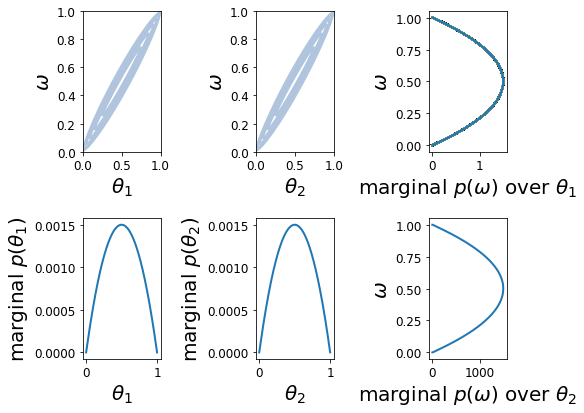

In [19]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3)

ax0 = plt.subplot(gs[0,0])
ax0.contour(T1, Omega, prior1, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta_1$')
ax0.set_ylabel(r'$\omega$')

ax0 = plt.subplot(gs[0,1])
ax0.contour(T2, Omega, prior2, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta_2$')
ax0.set_ylabel(r'$\omega$')

ax2 = plt.subplot(gs[0,2])
ax2.plot(normalize(np.sum(prior1,axis = 1)) * len(Omega), Omega)
ax2.set_xlabel(r'marginal $p(\omega)$ over $\theta_1$')
ax2.set_ylabel(r'$\omega$')

ax3 = plt.subplot(gs[1,0])
ax3.plot(thetas, normalize(np.sum(prior1,axis = 1)))
ax3.set_ylabel(r'marginal $p(\theta_1)$')
ax3.set_xlabel(r'$\theta_1$')

ax4 = plt.subplot(gs[1,1])
ax4.plot(thetas, normalize(np.sum(prior2,axis = 1)))
ax4.set_ylabel(r'marginal $p(\theta_2)$')
ax4.set_xlabel(r'$\theta_2$')

ax5 = plt.subplot(gs[1,2])
ax5.plot(np.sum(prior2,axis = 0), omegas)
ax5.set_xlabel(r'marginal $p(\omega)$ over $\theta_2$')
ax5.set_ylabel(r'$\omega$')

fig.tight_layout()

##### Posterior - NOT RIGHT

In [20]:
## Person 1
Number_words_1 = 15
Memorized_1 = 3

## Person 2
Number_words_2 = 5
Memorized_2 = 4

likelihood_1 = binom.pmf(Memorized_1, Number_words_1,T1)
likelihood_2 = binom.pmf(Memorized_2, Number_words_2,T2)

prob_data_1 = np.multiply(prior1,likelihood_1).sum()
posterior_1 = np.multiply(prior1,likelihood_1) / prob_data_1

prob_data_2 = np.multiply(prior2,likelihood_2).sum()
posterior_2 = np.multiply(prior2,likelihood_2) / prob_data_2

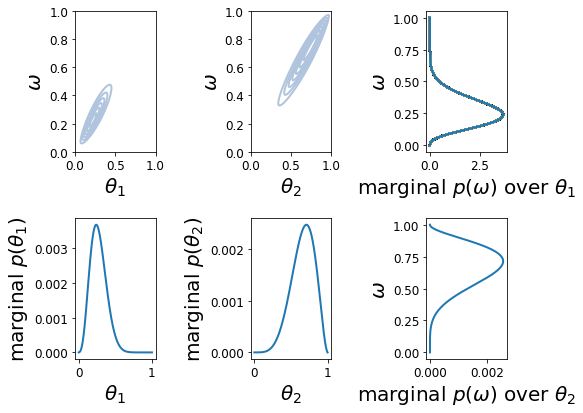

In [21]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3)

ax0 = plt.subplot(gs[0,0])
ax0.contour(T1, Omega, posterior_1, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta_1$')
ax0.set_ylabel(r'$\omega$')

ax0 = plt.subplot(gs[0,1])
ax0.contour(T2, Omega, posterior_2, colors = 'lightsteelblue')
ax0.set_xlabel(r'$\theta_2$')
ax0.set_ylabel(r'$\omega$')

ax2 = plt.subplot(gs[0,2])
ax2.plot(normalize(np.sum(posterior_1,axis = 1)) * len(Omega), Omega)
ax2.set_xlabel(r'marginal $p(\omega)$ over $\theta_1$')
ax2.set_ylabel(r'$\omega$')

ax3 = plt.subplot(gs[1,0])
ax3.plot(thetas, normalize(np.sum(posterior_1,axis = 1)))
ax3.set_ylabel(r'marginal $p(\theta_1)$')
ax3.set_xlabel(r'$\theta_1$')

ax4 = plt.subplot(gs[1,1])
ax4.plot(thetas, normalize(np.sum(posterior_2,axis = 1)))
ax4.set_ylabel(r'marginal $p(\theta_2)$')
ax4.set_xlabel(r'$\theta_2$')

ax5 = plt.subplot(gs[1,2])
ax5.plot(np.sum(posterior_2,axis = 0), omegas)
ax5.set_xlabel(r'marginal $p(\omega)$ over $\theta_2$')
ax5.set_ylabel(r'$\omega$')

fig.tight_layout()

## Realistic Heirarchical Models

In normal situations, the value of $\kappa$ is never known. Instead, we use the data to estimate values of $\kappa$. Thus, there needs to be a new prior for $\kappa$ also. In the above case, $\kappa - 2$ must be non-negative, so we will use a gamma distribution as its prior knowledge. 

The gamma function is defined as

$$ \gamma(\kappa \vert s,r) = \frac{r^s}{\Gamma(s)}\kappa^{s-1}\exp^{-r\kappa} $$

where 

$$\Gamma(s) = \int_0^{\inf} t^{s-1}\exp^t dt$$ 

In the formula, the shape parameter is $s = \frac{\mu^2}{\sigma^2}$ and the rate parameter is $r = \frac{\mu}{\sigma^2}$ where $\mu$ is the mean and $\sigma$ is the standard deviation. Sometimes, a scale parameter, $\theta$, is used instead of $r$ where $\theta$ is the inverse of $r$. The parameters can also be defined as a function of the mode, $\omega$.

$$ s = 1 + \omega r $$
$$ r = \frac{\omega + \sqrt{\omega^2 + 4\sigma^2}}{2\sigma^2} $$

Below are some examples of gamma distributions.

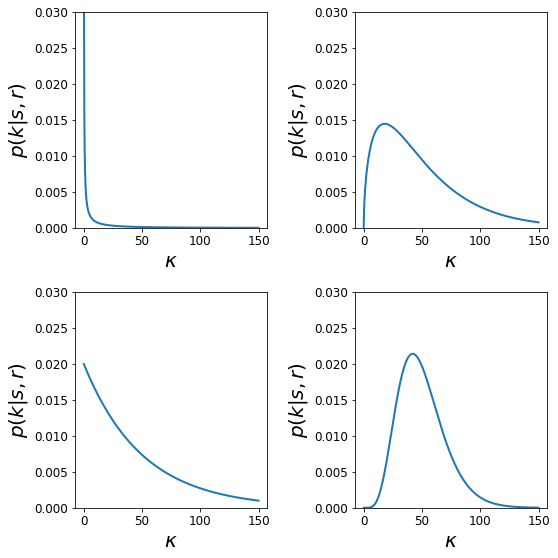

In [388]:
from scipy.stats import gamma

fig, axs = plt.subplots(2,2)

kappas = np.linspace(0,150,1001)
axs[0,0].plot(kappas, gamma.pdf(kappas, a = 0.01, scale = 1/0.01));
axs[0,0].set_ylim(0,0.03);
axs[0,0].set_ylabel(r'$p(k \vert s,r)$');
axs[0,0].set_xlabel(r'$\kappa$');
axs[0,1].plot(kappas, gamma.pdf(kappas, a = 1.56, scale = 1/0.0312));
axs[0,1].set_ylim(0,0.03);
axs[0,1].set_ylabel(r'$p(k \vert s,r)$');
axs[0,1].set_xlabel(r'$\kappa$');
axs[1,0].plot(kappas, gamma.pdf(kappas, a = 1, scale = 1/0.02));
axs[1,0].set_ylim(0,0.03);
axs[1,0].set_ylabel(r'$p(k \vert s,r)$');
axs[1,0].set_xlabel(r'$\kappa$');
axs[1,1].plot(kappas, gamma.pdf(kappas, a = 6.25, scale = 1/.125));
axs[1,1].set_ylim(0,0.03);
axs[1,1].set_ylabel(r'$p(k \vert s,r)$');
axs[1,1].set_xlabel(r'$\kappa$');

fig.tight_layout()

#FINISH

### Therapeutic Touch

Rosa et al (1998) was investigating whether or not people can sense whenever another person's hand was close by. In the experiment, a coin was flipped. Depending on the flip, the experimenter held their hand close to the subject's hand and the subject was asked to guess if the experimenter's hand was close by. There were 28 subjects with 10 trials each.

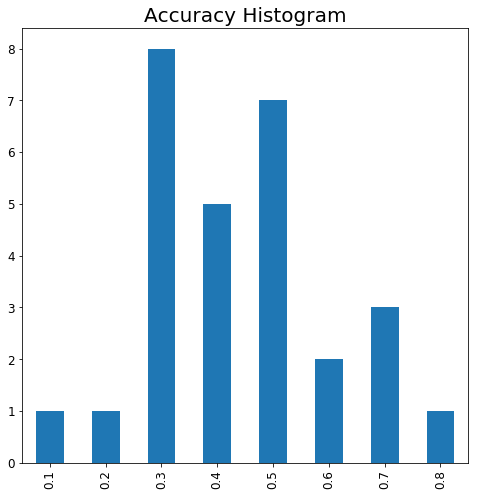

In [22]:
touch_data_df = pd.read_csv('TherapeuticTouchData.csv', dtype={'s':'category'})
data = touch_data_df.groupby('s').sum().apply(lambda x: x / 10)
touch_data = touch_data_df.groupby('s').sum().apply(lambda x: x / 10)['y'].tolist()
counts = Counter(touch_data)
df = pd.DataFrame.from_dict(counts, orient='index')
df.plot(kind='bar', legend=False, title = 'Accuracy Histogram');

In [23]:
person_index = touch_data_df.s.cat.codes.tolist()
N = len(touch_data_df.s.unique())

In [24]:
with pm.Model() as model:
    # parameters
    omega = pm.Beta('omega', 2, 2)
    kappa = pm.Gamma('kappa', mu = 1, sd = 10)
    
    # define the prior
    theta = pm.Beta('theta', omega * kappa, (1 - omega) * kappa, shape=N)
    
    # define the likelihood
    y = pm.Bernoulli('y', p=theta[person_index], observed=touch_data_df.y)
    
#   Generate a MCMC chain
    trace = pm.sample(10000, tune=2000, burn=200, thin=10, nuts_kwargs={'target_accept': 0.90})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__, kappa_log__, omega_logodds__]
100%|██████████| 12000/12000 [00:37<00:00, 320.49it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


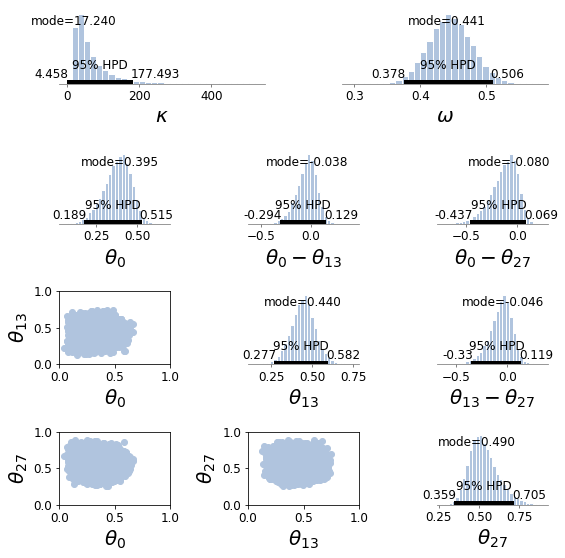

In [25]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 6)

ax = plt.subplot(gs[0,0:3])
pm.plots.plot_posterior(trace['kappa'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\kappa$')

ax = plt.subplot(gs[0,3:6])
pm.plots.plot_posterior(trace['omega'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega$')



ax = plt.subplot(gs[1,0:2])
pm.plots.plot_posterior(trace['theta'][:,0] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0$')

ax = plt.subplot(gs[1,2:4])
pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,13] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0 - \theta_{13}$')

ax = plt.subplot(gs[1,4:6])
pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0 - \theta_{27}$')



ax = plt.subplot(gs[2,0:2])
ax.scatter(trace['theta'][:,0],trace['theta'][:,13], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'$\theta_{13}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[2,2:4])
pm.plots.plot_posterior(trace['theta'][:,13] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{13}$')

ax = plt.subplot(gs[2,4:6])
pm.plots.plot_posterior(trace['theta'][:,13] - trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{13} - \theta_{27}$')



ax = plt.subplot(gs[3,0:2])
ax.scatter(trace['theta'][:,0],trace['theta'][:,27], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'$\theta_{27}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[3,2:4])
ax.scatter(trace['theta'][:,13],trace['theta'][:,27], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{13}$')
ax.set_ylabel(r'$\theta_{27}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[3,4:6])
pm.plots.plot_posterior(trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{27}$')

plt.tight_layout()
plt.show()

The worst performing $\theta_0$ and best performing $\theta_{27}$ both included 0.5 in the credible interval. Thus, it cannot be included that the subjects performed better than chance.

## Shrinkage in Heirarchical Models

In heirarchical models, low level parameters are pulled closer together. Thus, in the above example, the credible values of $\theta$ are closer to the group mode $\omega$ than the the individual proportions. In other words, shrinkage refers to the reduction of variance in the estimators.

## Extending the Heirarchy - Baseball Batting Abilities by Position

The model can be extended to infinite levels. For example, one possible situation is the ability of many baseball players to get a hit grouped by player position. Given subject $s$ and category $c$, $y_i \vert _{s,c}$ is an individual trial. The bias of $s$ in category $c$ is denoted by $\theta_s \vert _c$ and is distributed as a beta density function with mode $\omega_c$ and concentration $\kappa_c$. All category modes are drawn from a higher level beta distribution with estimated mode $\omega$ and estimated concentration $\kappa$. For simplicity, the concentration of each category is drawn from a gamma distribution with constant parameters (not estimated) $S_k$ and $R_k$. 

In [26]:
baseball = pd.read_csv('BattingAverage.csv')
baseball.PriPosNumber = baseball.PriPosNumber.apply(lambda x: x-1)
positions = baseball.groupby('PriPos')['Hits','AtBats'].sum()
averages = positions.Hits / positions.AtBats

In [27]:
n_positions = len(averages)
n_players = len(baseball)
positions_index = baseball.PriPosNumber.tolist()
code_positions = dict(zip(baseball.PriPos,baseball.PriPosNumber))
code_players = dict(zip(baseball.Player,baseball.index))
players_position = dict(zip(baseball.Player,baseball.PriPos))

In [31]:
with pm.Model() as model:
    # highest order parameters prior
    omega = pm.Beta('omega', 2, 2)
    kappa = pm.Gamma('kappa', 1, 0.1)
    
    # position parameters prior
    omega_c = pm.Beta('omega_c', omega*(kappa)+1, (1-omega)*(kappa)+1,
                       shape = n_positions)
    kappa_c = pm.Gamma('kappa_c',1, 0.01,shape = n_positions)
    
    #  person prior
    theta = pm.Beta('theta',
                     omega_c[positions_index]*(kappa_c[positions_index])+1,
                    (1-omega_c[positions_index])*(kappa_c[positions_index])+1,
                     shape = n_players)
    
    # likelihood
    y = pm.Binomial('y', n=baseball.AtBats, p=theta, observed=baseball.Hits)
    
    trace = pm.sample(10000, tune=2000, burn=200, thin=10, nuts_kwargs={'target_accept': 0.90})
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__, kappa_c_log__, omega_c_logodds__, kappa_log__, omega_logodds__]
100%|██████████| 12000/12000 [03:35<00:00, 55.64it/s]
The number of effective samples is smaller than 10% for some parameters.


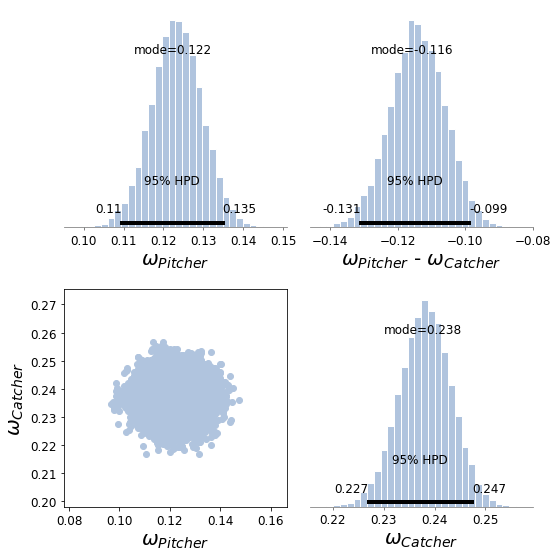

In [33]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

comp_1 = 'Pitcher'
comp_2 = 'Catcher'

ax = plt.subplot(gs[0,0])
pm.plots.plot_posterior(trace['omega_c'][:,code_positions[comp_1]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega_{' + comp_1 + '}$')

ax = plt.subplot(gs[0,1])
pm.plots.plot_posterior(trace['omega_c'][:,code_positions[comp_1]] - trace['omega_c'][:,code_positions[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega_{' + comp_1 + '}$ - ' + r'$\omega_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,0])
ax.scatter(trace['omega_c'][:,code_positions[comp_1]],trace['omega_c'][:,code_positions[comp_2]], color = 'lightsteelblue')
ax.set_xlabel(r'$\omega_{' + comp_1 + '}$')
ax.set_ylabel(r'$\omega_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,1])
pm.plots.plot_posterior(trace['omega_c'][:,code_positions[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega_{' + comp_2 + '}$')

plt.tight_layout()
plt.show()

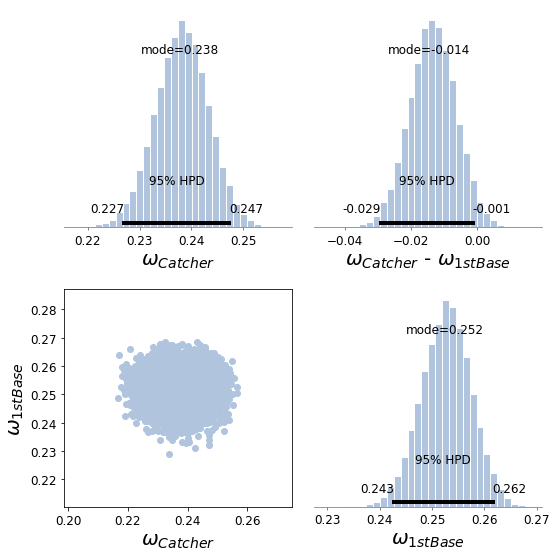

In [34]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

comp_1 = 'Catcher'
comp_2 = '1st Base'

ax = plt.subplot(gs[0,0])
pm.plots.plot_posterior(trace['omega_c'][:,code_positions[comp_1]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega_{' + comp_1 + '}$')

ax = plt.subplot(gs[0,1])
pm.plots.plot_posterior(trace['omega_c'][:,code_positions[comp_1]] - trace['omega_c'][:,code_positions[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega_{' + comp_1 + '}$ - ' + r'$\omega_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,0])
ax.scatter(trace['omega_c'][:,code_positions[comp_1]],trace['omega_c'][:,code_positions[comp_2]], color = 'lightsteelblue')
ax.set_xlabel(r'$\omega_{' + comp_1 + '}$')
ax.set_ylabel(r'$\omega_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,1])
pm.plots.plot_posterior(trace['omega_c'][:,code_positions[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega_{' + comp_2 + '}$')

plt.tight_layout()
plt.show()

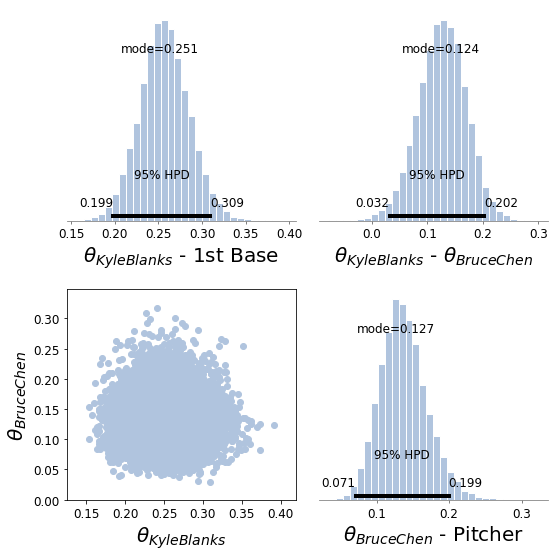

In [35]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

comp_1 = 'Kyle Blanks'
comp_2 = 'Bruce Chen'

ax = plt.subplot(gs[0,0])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_1]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$ - ' + players_position[comp_1])

ax = plt.subplot(gs[0,1])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_1]] - trace['theta'][:,code_players[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$ - ' + r'$\theta_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,0])
ax.scatter(trace['theta'][:,code_players[comp_1]],trace['theta'][:,code_players[comp_2]], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$')
ax.set_ylabel(r'$\theta_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,1])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_2 + '}$ - ' + players_position[comp_2])

plt.tight_layout()
plt.show()

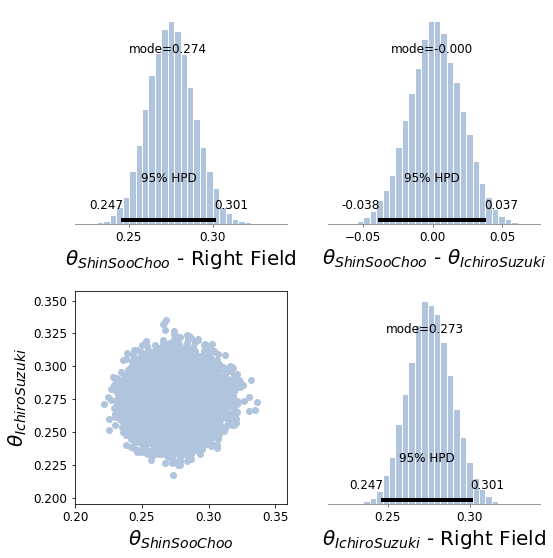

In [36]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

comp_1 = 'ShinSoo Choo'
comp_2 = 'Ichiro Suzuki'

ax = plt.subplot(gs[0,0])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_1]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$ - ' + players_position[comp_1])

ax = plt.subplot(gs[0,1])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_1]] - trace['theta'][:,code_players[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$ - ' + r'$\theta_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,0])
ax.scatter(trace['theta'][:,code_players[comp_1]],trace['theta'][:,code_players[comp_2]], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$')
ax.set_ylabel(r'$\theta_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,1])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_2 + '}$ - ' + players_position[comp_2])

plt.tight_layout()
plt.show()

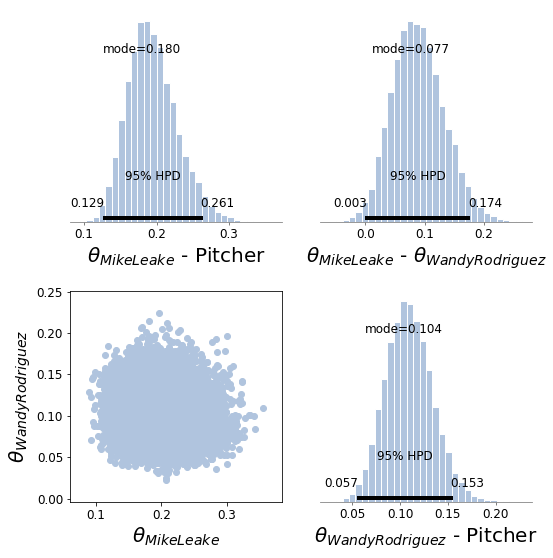

In [372]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

comp_1 = 'Mike Leake'
comp_2 = 'Wandy Rodriguez'

ax = plt.subplot(gs[0,0])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_1]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$ - ' + players_position[comp_1])

ax = plt.subplot(gs[0,1])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_1]] - trace['theta'][:,code_players[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$ - ' + r'$\theta_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,0])
ax.scatter(trace['theta'][:,code_players[comp_1]],trace['theta'][:,code_players[comp_2]], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$')
ax.set_ylabel(r'$\theta_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,1])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_2 + '}$ - ' + players_position[comp_2])

plt.tight_layout()
plt.show()

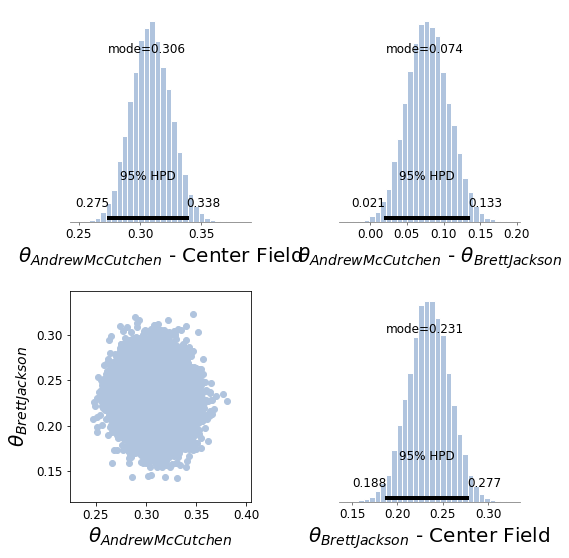

In [37]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

comp_1 = 'Andrew McCutchen'
comp_2 = 'Brett Jackson'

ax = plt.subplot(gs[0,0])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_1]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$ - ' + players_position[comp_1])

ax = plt.subplot(gs[0,1])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_1]] - trace['theta'][:,code_players[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$ - ' + r'$\theta_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,0])
ax.scatter(trace['theta'][:,code_players[comp_1]],trace['theta'][:,code_players[comp_2]], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{' + comp_1 + '}$')
ax.set_ylabel(r'$\theta_{' + comp_2 + '}$')

ax = plt.subplot(gs[1,1])
pm.plots.plot_posterior(trace['theta'][:,code_players[comp_2]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{' + comp_2 + '}$ - ' + players_position[comp_2])

plt.tight_layout()
plt.show()

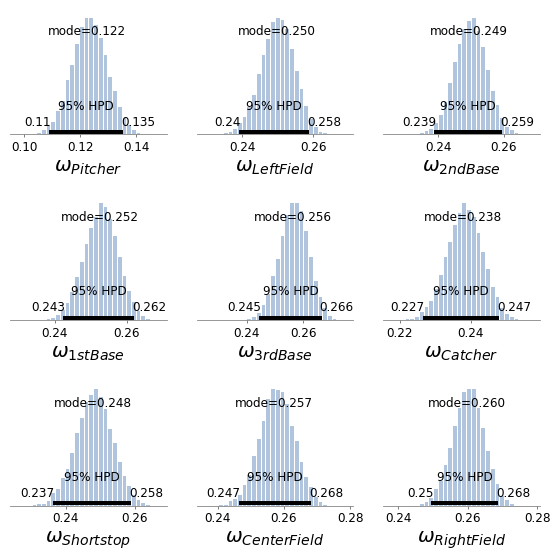

In [39]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 3)

i = 0
j = 0
for position in code_positions.keys():
        
    ax = plt.subplot(gs[i,j])
    pm.plots.plot_posterior(trace['omega_c'][:,code_positions[position]] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
    ax.set_xlabel(r'$\omega_{' + position + '}$')
    
    j += 1
    if j == 3:
        i += 1
        j = 0
    

plt.tight_layout()
plt.show()

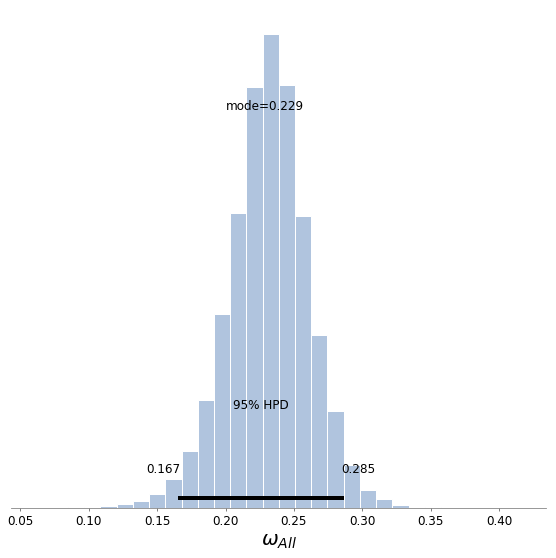

In [40]:
fig, ax = plt.subplots(1)

position = 'All'
ax = plt.subplot()
pm.plots.plot_posterior(trace['omega'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega_{' + position + '}$')

plt.tight_layout()
plt.show()

# Chapter 9: Exercises 

## Exercise 9.1

Exercise 9.1. [Purpose: Try different priors on $\kappa$ to explore the role of $\kappa$ in shrinkage.] Consider the analysis of the therapeutic touch data in Figure 9.10, p. 243. The analysis used a generic gamma distributed prior on $\kappa$ that had a mean of 1.0 and a standard deviation of 10.0. We assumed that the prior had minimal influence on the results; here, we examine the robustness of the posterior when we change the prior to other reasonably vague and noncommittal distributions. In particular, we will examine a gamma distributed prior on $\kappa$ that had a mode of 1.0 and a standard deviation of 10.0.

(A) What are the shape and rate parameters for a gamma distribution that has mean of 1.0 and standard deviation of 10.0? What are the shape and rate parameters for a gamma distribution that has mode of 1.0 and standard deviation of 10.0? 


In [41]:
mu = 1
sigma = 10
omega = 1
print('mean = ', mu)
print('standard deviation = ', sigma)
print('shape = ', mu**2/sigma**2)
print('rate = ', mu/sigma**2)
print('\n')
print('mode = ', omega)
print('rate = ',(omega + (omega**2 + 4 * sigma**2)**0.5) / (2 * sigma**2))
print('shape = ', 1 + omega * (omega + (omega**2 + 4 * sigma**2)**0.5) / (2 * sigma**2))

mean =  1
standard deviation =  10
shape =  0.01
rate =  0.01


mode =  1
rate =  0.10512492197250393
shape =  1.105124921972504


(B) Plot the two gamma distributions, superimposed, to see which values of $\kappa$ they emphasize. Relative to each other, which gamma distribution favors values of $\kappa$ between about 0.1 and 75? Which gamma distribution favors values of $\kappa$ that are tiny or greater than 75?

Answer: The distribution with a mode of 1 favors values of $\kappa$ between 0.1 and 75. The distribution with a mean of 1 favors values that are smaller than 0.1 or larger than 75.

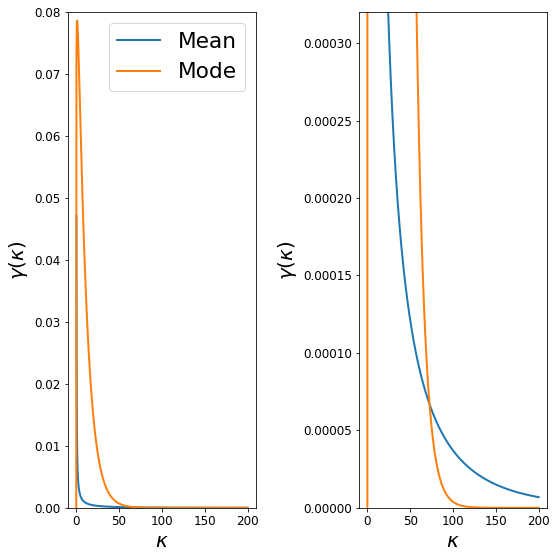

In [43]:
from scipy.stats import gamma

fig, ax = plt.subplots(1,2)

kappas = np.linspace(0,200,1001)

shape_mean = mu**2/sigma**2
rate_mean = mu/sigma**2
rate_mode = (omega + (omega**2 + 4 * sigma**2)**0.5) / (2 * sigma**2)
shape_mode = 1 + omega * (omega + (omega**2 + 4 * sigma**2)**0.5) / (2 * sigma**2)

ax[0].plot(kappas, gamma.pdf(kappas, a = shape_mean, scale = 1/rate_mean),label='Mean');
ax[0].plot(kappas, gamma.pdf(kappas, a = shape_mode, scale = 1/rate_mode),label='Mode');
legend = ax[0].legend(fontsize='x-large')
ax[0].set_ylim(0,0.08);
ax[0].set_ylabel(r'$\gamma(\kappa)$');
ax[0].set_xlabel(r'$\kappa$');

ax[1].plot(kappas, gamma.pdf(kappas, a = shape_mean, scale = 1/rate_mean),label='Mean');
ax[1].plot(kappas, gamma.pdf(kappas, a = shape_mode, scale = 1/rate_mode),label='Mode');
ax[1].set_ylim(0,5**-5);
ax[1].set_ylabel(r'$\gamma(\kappa)$');
ax[1].set_xlabel(r'$\kappa$');

fig.tight_layout()

(C) Run the program once using a gamma with mean of 1.0, and run the program a second time using a gamma with a mode of 1.0. Show the graphs of the posterior distribution.

In [44]:
touch_data_df = pd.read_csv('TherapeuticTouchData.csv', dtype={'s':'category'})

person_index = touch_data_df.s.cat.codes.tolist()
N = len(touch_data_df.s.unique())

with pm.Model() as model:
    # parameters
    omega = pm.Beta('omega', 2, 2)
    kappa = pm.Gamma('kappa', mu = 1, sd = 10)
    
    # define the prior
    theta = pm.Beta('theta', omega * kappa, (1 - omega) * kappa, shape=N)
    
    # define the likelihood
    y = pm.Bernoulli('y', p=theta[person_index], observed=touch_data_df.y)
    
#   Generate a MCMC chain
    trace = pm.sample(10000, tune=2000, burn=200, thin=10, nuts_kwargs={'target_accept': 0.90})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__, kappa_log__, omega_logodds__]
100%|██████████| 12000/12000 [00:55<00:00, 216.86it/s]
The number of effective samples is smaller than 10% for some parameters.


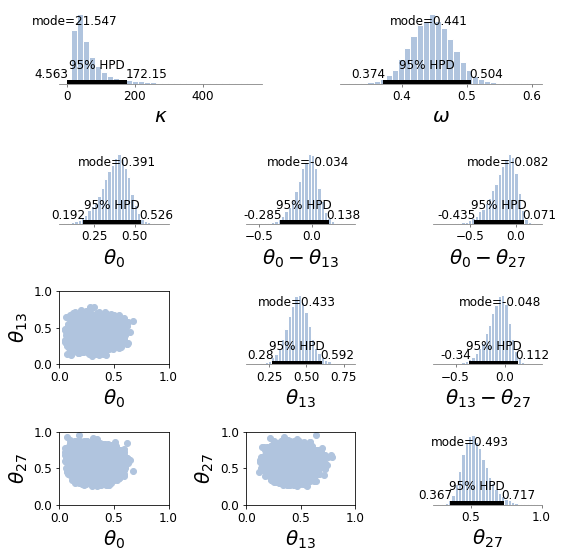

In [45]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 6)

ax = plt.subplot(gs[0,0:3])
pm.plots.plot_posterior(trace['kappa'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\kappa$')

ax = plt.subplot(gs[0,3:6])
pm.plots.plot_posterior(trace['omega'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega$')



ax = plt.subplot(gs[1,0:2])
pm.plots.plot_posterior(trace['theta'][:,0] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0$')

ax = plt.subplot(gs[1,2:4])
pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,13] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0 - \theta_{13}$')

ax = plt.subplot(gs[1,4:6])
pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0 - \theta_{27}$')



ax = plt.subplot(gs[2,0:2])
ax.scatter(trace['theta'][:,0],trace['theta'][:,13], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'$\theta_{13}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[2,2:4])
pm.plots.plot_posterior(trace['theta'][:,13] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{13}$')

ax = plt.subplot(gs[2,4:6])
pm.plots.plot_posterior(trace['theta'][:,13] - trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{13} - \theta_{27}$')



ax = plt.subplot(gs[3,0:2])
ax.scatter(trace['theta'][:,0],trace['theta'][:,27], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'$\theta_{27}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[3,2:4])
ax.scatter(trace['theta'][:,13],trace['theta'][:,27], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{13}$')
ax.set_ylabel(r'$\theta_{27}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[3,4:6])
pm.plots.plot_posterior(trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{27}$')

plt.tight_layout()
plt.show()

In [46]:
with pm.Model() as model:
    # parameters
    omega = pm.Beta('omega', 2, 2)
    kappa = pm.Gamma('kappa', alpha = shape_mode, beta = rate_mode)
    
    # define the prior
    theta = pm.Beta('theta', omega * kappa, (1 - omega) * kappa, shape=N)
    
    # define the likelihood
    y = pm.Bernoulli('y', p=theta[person_index], observed=touch_data_df.y)
    
#   Generate a MCMC chain
    trace = pm.sample(10000, tune=2000, burn=200, thin=10, nuts_kwargs={'target_accept': 0.90})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__, kappa_log__, omega_logodds__]
100%|██████████| 12000/12000 [00:35<00:00, 340.93it/s]


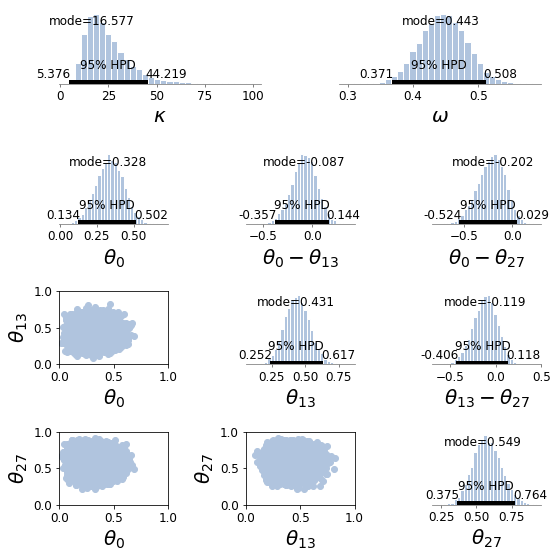

In [47]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 6)

ax = plt.subplot(gs[0,0:3])
pm.plots.plot_posterior(trace['kappa'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\kappa$')

ax = plt.subplot(gs[0,3:6])
pm.plots.plot_posterior(trace['omega'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega$')



ax = plt.subplot(gs[1,0:2])
pm.plots.plot_posterior(trace['theta'][:,0] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0$')

ax = plt.subplot(gs[1,2:4])
pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,13] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0 - \theta_{13}$')

ax = plt.subplot(gs[1,4:6])
pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0 - \theta_{27}$')



ax = plt.subplot(gs[2,0:2])
ax.scatter(trace['theta'][:,0],trace['theta'][:,13], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'$\theta_{13}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[2,2:4])
pm.plots.plot_posterior(trace['theta'][:,13] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{13}$')

ax = plt.subplot(gs[2,4:6])
pm.plots.plot_posterior(trace['theta'][:,13] - trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{13} - \theta_{27}$')



ax = plt.subplot(gs[3,0:2])
ax.scatter(trace['theta'][:,0],trace['theta'][:,27], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'$\theta_{27}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[3,2:4])
ax.scatter(trace['theta'][:,13],trace['theta'][:,27], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{13}$')
ax.set_ylabel(r'$\theta_{27}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[3,4:6])
pm.plots.plot_posterior(trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{27}$')

plt.tight_layout()
plt.show()

(D) Does the posterior distribution change much when the prior is changed? In particular, for which prior does the marginal posterior distribution on $\kappa$ have a bigger large-value tail? When $\kappa$ is larger, what effect does that have on shrinkage of the $\theta$ values?

Answer: The posterior does change when the prior changes. The distribution with mean = 1 has a bigger large-value tail. Larger $\kappa$ means more shrinkage on $\theta$.

## Exercise 9.2 - NOT DONE

Purpose: Examine the prior on $\theta$s implied by the prior constants at higher levels.] For both priors, include the graphs of the prior distributions on $\theta$s and the differences of $\theta$s such as theta[1]-theta[28]

(A) Explain why the implied prior distribution on individual $\theta$s has rounded shoulders (instead of being essentially uniform) when using a prior on $\kappa$ that has a mode of 1 (instead of a mean of 1).

(B) Which prior do you think is more appropriate?

In [81]:
touch_data_df = pd.read_csv('TherapeuticTouchData.csv', dtype={'s':'category'})

person_index = touch_data_df.s.cat.codes.tolist()
N = len(touch_data_df.s.unique())

with pm.Model() as model:
    # parameters
    omega = pm.Beta('omega', 2, 2)
    kappa = pm.Gamma('kappa', mu = 1, sd = 10)
    
    # define the prior
    theta = pm.Beta('theta', omega * kappa, (1 - omega) * kappa, shape=N)
    
    # define the likelihood
    y = pm.Bernoulli('y', p=theta[person_index])#, observed=touch_data_df.y)
    
#   Generate a MCMC chain
    trace = pm.sample(10000, tune=2000, burn=200, thin=10, nuts_kwargs={'target_accept': 0.90})

    
# import pymc3 as pm

# with pm.Model() as m:
#     mu = pm.Normal('mu', mu=0, sd=10)
#     sigma = pm.Uniform('sigma', lower=0, upper=10)
#     y = pm.Normal('y', mu=mu, sd=sigma)
#     trace = pm.sample(1000, tune=1000)


TypeError: For compute_test_value, one input test value does not have the requested type.

The error when converting the test value to that variable type:
Wrong number of dimensions: expected 0, got 1 with shape (280,).

In [ ]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 6)

ax = plt.subplot(gs[0,0:3])
pm.plots.plot_posterior(trace['kappa'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\kappa$')

ax = plt.subplot(gs[0,3:6])
pm.plots.plot_posterior(trace['omega'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega$')



ax = plt.subplot(gs[1,0:2])
pm.plots.plot_posterior(trace['theta'][:,0] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0$')

ax = plt.subplot(gs[1,2:4])
pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,13] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0 - \theta_{13}$')

ax = plt.subplot(gs[1,4:6])
pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_0 - \theta_{27}$')



ax = plt.subplot(gs[2,0:2])
ax.scatter(trace['theta'][:,0],trace['theta'][:,13], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'$\theta_{13}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[2,2:4])
pm.plots.plot_posterior(trace['theta'][:,13] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{13}$')

ax = plt.subplot(gs[2,4:6])
pm.plots.plot_posterior(trace['theta'][:,13] - trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{13} - \theta_{27}$')



ax = plt.subplot(gs[3,0:2])
ax.scatter(trace['theta'][:,0],trace['theta'][:,27], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'$\theta_{27}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[3,2:4])
ax.scatter(trace['theta'][:,13],trace['theta'][:,27], color = 'lightsteelblue')
ax.set_xlabel(r'$\theta_{13}$')
ax.set_ylabel(r'$\theta_{27}$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs[3,4:6])
pm.plots.plot_posterior(trace['theta'][:,27] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\theta_{27}$')

plt.tight_layout()
plt.show()

## Exercise 9.3 - Answer Question

Construct a data set like the data in Figure 9.12 and do a Bayesian analysis like that done for the therapeutic touch data. Compare the Bayesian parameter estimates with the MLE estimates (gleaned from Figure 9.12). What does the Bayesian analysis provide that is not provided by the MLE?

In [160]:
N = 5
trials = 10
success = [0.3,0.4,0.5,0.6,0.7]
y = []
for x in success:
    amount = int(trials * x)
    y += [1] * amount + [0] * (trials - amount)

s = sorted([x for y in range(trials) for x in range(N)])
fake_data_df = pd.DataFrame({'y':y, 's':s})


In [161]:
person_index = fake_data_df.s.tolist()
N = len(fake_data_df.s.unique())

with pm.Model() as model:
    # parameters
    omega = pm.Beta('omega', 2, 2)
    kappa = pm.Gamma('kappa', alpha = 2, beta = 2)
    
    # define the prior
    theta = pm.Beta('theta', omega * kappa, (1 - omega) * kappa, shape=N)
    
    # define the likelihood
    y = pm.Bernoulli('y', p=theta[person_index], observed=fake_data_df.y)
    
#   Generate a MCMC chain
    trace = pm.sample(10000, tune=2000, burn=200, thin=10, nuts_kwargs={'target_accept': 0.90})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__, kappa_log__, omega_logodds__]
100%|██████████| 12000/12000 [00:17<00:00, 685.44it/s]


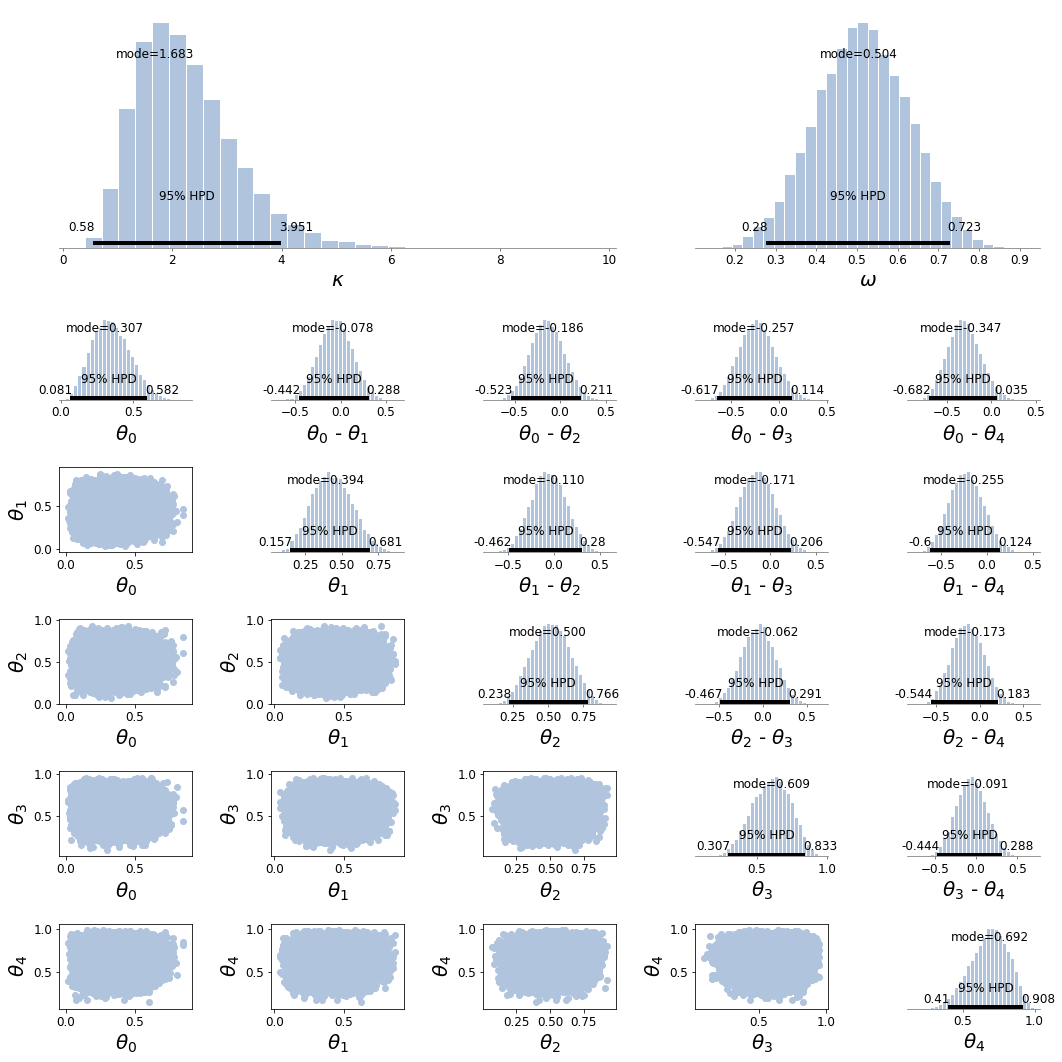

In [162]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(7, 5)

ax = plt.subplot(gs[0:2,0:3])
pm.plots.plot_posterior(trace['kappa'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\kappa$')

ax = plt.subplot(gs[0:2,3:6])
pm.plots.plot_posterior(trace['omega'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega$')


for i in range(5):
    
    ax = plt.subplot(gs[2 + i,i])
    pm.plots.plot_posterior(trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
    ax.set_xlabel(r'$\theta_' + str(i) + '$')
    
    if i > 0:
        ax = plt.subplot(gs[2,i])
        pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
        ax.set_xlabel(r'$\theta_0$ - ' + r'$\theta_{' + str(i) + '}$')

    if i > 1:
        ax = plt.subplot(gs[3,i])
        pm.plots.plot_posterior(trace['theta'][:,1] - trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
        ax.set_xlabel(r'$\theta_1$ - ' + r'$\theta_{' + str(i) + '}$')
    
    if i > 2:
        ax = plt.subplot(gs[4,i])
        pm.plots.plot_posterior(trace['theta'][:,2] - trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
        ax.set_xlabel(r'$\theta_2$ - ' + r'$\theta_{' + str(i) + '}$')

    if i > 3:
        ax = plt.subplot(gs[5,i])
        pm.plots.plot_posterior(trace['theta'][:,3] - trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
        ax.set_xlabel(r'$\theta_3$ - ' + r'$\theta_{' + str(i) + '}$')
        
    if i < 4:
        ax = plt.subplot(gs[6,i])
        ax.scatter(trace['theta'][:,i],trace['theta'][:,4], color = 'lightsteelblue')
        ax.set_xlabel(r'$\theta_' + str(i) + '$')
        ax.set_ylabel(r'$\theta_{4}$')
        
    if i < 3:
        ax = plt.subplot(gs[5,i])
        ax.scatter(trace['theta'][:,i],trace['theta'][:,3], color = 'lightsteelblue')
        ax.set_xlabel(r'$\theta_' + str(i) + '$')
        ax.set_ylabel(r'$\theta_{3}$')
        
    if i < 2:
        ax = plt.subplot(gs[4,i])
        ax.scatter(trace['theta'][:,i],trace['theta'][:,2], color = 'lightsteelblue')
        ax.set_xlabel(r'$\theta_' + str(i) + '$')
        ax.set_ylabel(r'$\theta_{2}$')
        
    if i < 1:
        ax = plt.subplot(gs[3,i])
        ax.scatter(trace['theta'][:,i],trace['theta'][:,1], color = 'lightsteelblue')
        ax.set_xlabel(r'$\theta_' + str(i) + '$')
        ax.set_ylabel(r'$\theta_{1}$')

plt.tight_layout()
plt.show()

In [163]:
person_index = fake_data_df.s.tolist()
N = len(fake_data_df.s.unique())

with pm.Model() as model:
    # parameters
    omega = pm.Beta('omega', 2, 2)
    kappa = pm.Uniform('kappa', lower = 0, upper = 1)
    
    # define the prior
    theta = pm.Beta('theta', omega * kappa, (1 - omega) * kappa, shape=N)
    
    # define the likelihood
    y = pm.Bernoulli('y', p=theta[person_index], observed=fake_data_df.y)
    
#   Generate a MCMC chain
    trace = pm.sample(10000, tune=2000, burn=200, thin=10, nuts_kwargs={'target_accept': 0.90})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__, kappa_interval__, omega_logodds__]
100%|██████████| 12000/12000 [00:16<00:00, 714.84it/s]


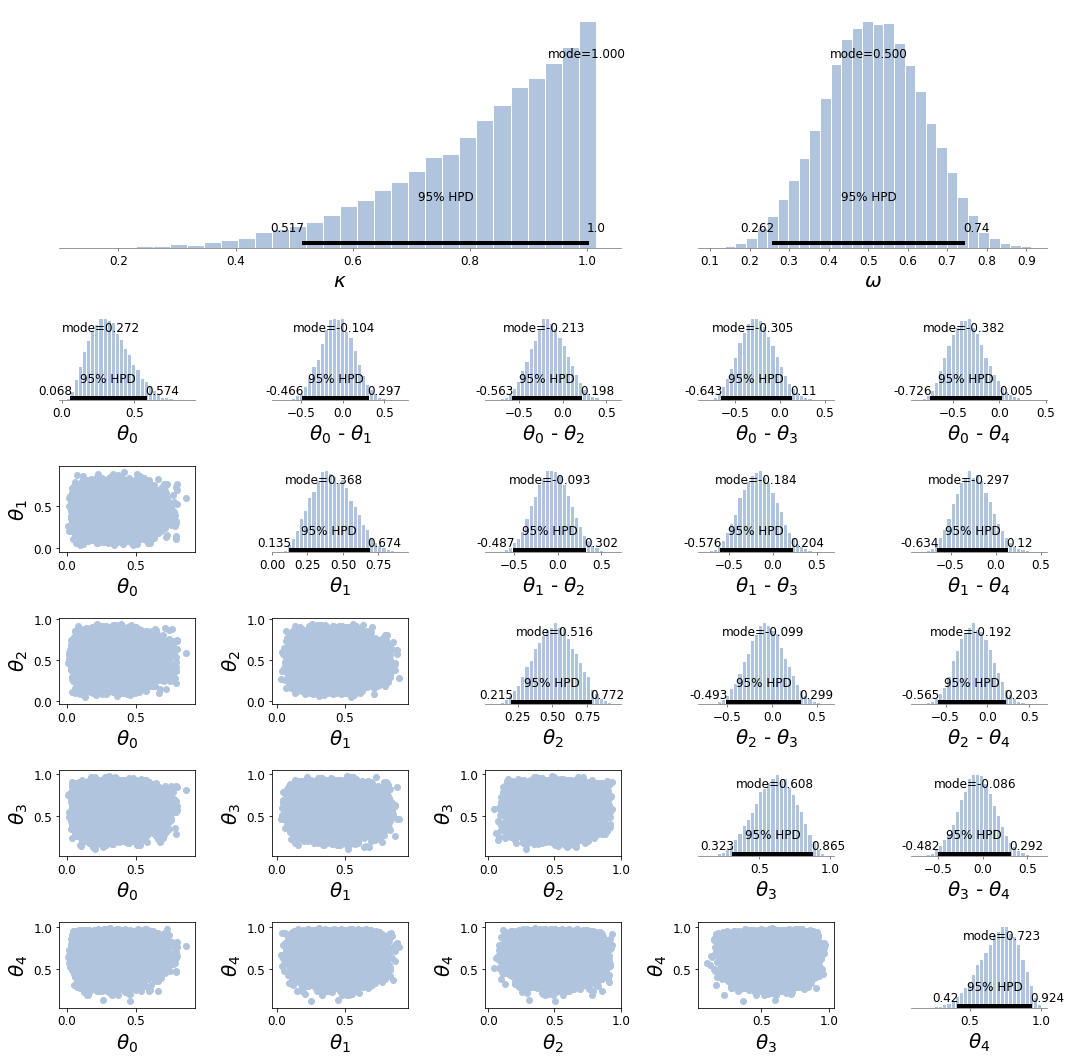

In [164]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(7, 5)

ax = plt.subplot(gs[0:2,0:3])
pm.plots.plot_posterior(trace['kappa'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\kappa$')

ax = plt.subplot(gs[0:2,3:6])
pm.plots.plot_posterior(trace['omega'], label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
ax.set_xlabel(r'$\omega$')


for i in range(5):
    
    ax = plt.subplot(gs[2 + i,i])
    pm.plots.plot_posterior(trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
    ax.set_xlabel(r'$\theta_' + str(i) + '$')
    
    if i > 0:
        ax = plt.subplot(gs[2,i])
        pm.plots.plot_posterior(trace['theta'][:,0] - trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
        ax.set_xlabel(r'$\theta_0$ - ' + r'$\theta_{' + str(i) + '}$')

    if i > 1:
        ax = plt.subplot(gs[3,i])
        pm.plots.plot_posterior(trace['theta'][:,1] - trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
        ax.set_xlabel(r'$\theta_1$ - ' + r'$\theta_{' + str(i) + '}$')
    
    if i > 2:
        ax = plt.subplot(gs[4,i])
        pm.plots.plot_posterior(trace['theta'][:,2] - trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
        ax.set_xlabel(r'$\theta_2$ - ' + r'$\theta_{' + str(i) + '}$')

    if i > 3:
        ax = plt.subplot(gs[5,i])
        pm.plots.plot_posterior(trace['theta'][:,3] - trace['theta'][:,i] , label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
        ax.set_xlabel(r'$\theta_3$ - ' + r'$\theta_{' + str(i) + '}$')
        
    if i < 4:
        ax = plt.subplot(gs[6,i])
        ax.scatter(trace['theta'][:,i],trace['theta'][:,4], color = 'lightsteelblue')
        ax.set_xlabel(r'$\theta_' + str(i) + '$')
        ax.set_ylabel(r'$\theta_{4}$')
        
    if i < 3:
        ax = plt.subplot(gs[5,i])
        ax.scatter(trace['theta'][:,i],trace['theta'][:,3], color = 'lightsteelblue')
        ax.set_xlabel(r'$\theta_' + str(i) + '$')
        ax.set_ylabel(r'$\theta_{3}$')
        
    if i < 2:
        ax = plt.subplot(gs[4,i])
        ax.scatter(trace['theta'][:,i],trace['theta'][:,2], color = 'lightsteelblue')
        ax.set_xlabel(r'$\theta_' + str(i) + '$')
        ax.set_ylabel(r'$\theta_{2}$')
        
    if i < 1:
        ax = plt.subplot(gs[3,i])
        ax.scatter(trace['theta'][:,i],trace['theta'][:,1], color = 'lightsteelblue')
        ax.set_xlabel(r'$\theta_' + str(i) + '$')
        ax.set_ylabel(r'$\theta_{1}$')

plt.tight_layout()
plt.show()